In [138]:
import pandas as pd
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.neighbors import KNeighborsClassifier  # модель с минимальной полнотой
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import matplotlib.pyplot as plt
import warnings

In [35]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
y_true = pd.read_csv('titanic_test.csv')["Survived"]

In [36]:
# подготовка датафрейма

def age_nan(x, y, a, b):
    ans = []
    for i in range(len(x)):
        if y[i] >- 1:
            ans.append(y[i])
        else:
            if x[i] == 'male':
                ans.append(a)
            else:
                ans.append(b)
    return ans
    

male_median, female_median = df.groupby('Sex')["Age"].agg('median')

df[['Cabin', 'Embarked']] = df[['Cabin', 'Embarked']].fillna('U')
df["Age"] = age_nan(df["Sex"], df["Age"], male_median, female_median)
df["Sex"] = df["Sex"].map({'male':0, 'female':1})
df["Embarked"] = df["Embarked"].map({'U':0, 'S':1, 'C':2, 'Q':3,})

del df['PassengerId'], df['Name'], df['Ticket'], df['Cabin']
y_train = df["Survived"]
del df["Survived"]
df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,2
2,3,1,26.0,0,0,7.9250,1
3,1,1,35.0,1,0,53.1000,1
4,3,0,35.0,0,0,8.0500,1
...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,1
887,1,1,19.0,0,0,30.0000,1
888,3,1,29.0,1,2,23.4500,1
889,1,0,26.0,0,0,30.0000,2


In [37]:
df_test["Age"] = age_nan(df_test["Sex"], df_test["Age"], male_median, female_median)
df_test["Sex"] = df_test["Sex"].map({'male':0, 'female':1})
df_test["Embarked"] = df_test["Embarked"].map({'U':0, 'S':1, 'C':2, 'Q':3,})

del df_test['PassengerId'], df_test['Name'], df_test['Ticket'], df_test['Cabin']
df_test["Fare"] = df_test["Fare"].fillna(df_test["Fare"].mean())
df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,3
1,3,1,47.0,1,0,7.0000,1
2,2,0,62.0,0,0,9.6875,3
3,3,0,27.0,0,0,8.6625,1
4,3,1,22.0,1,1,12.2875,1
...,...,...,...,...,...,...,...
413,3,0,27.0,0,0,8.0500,1
414,1,1,39.0,0,0,108.9000,2
415,3,0,38.5,0,0,7.2500,1
416,3,0,27.0,0,0,8.0500,1


In [76]:
X_train, X_test = df, df_test

In [83]:
# K-Nearest-Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn_model = knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

precision = precision_score(y_true, knn_pred)
recall = recall_score(y_true, knn_pred)

In [84]:
def f1_ours(beta):
    return (1+beta**2)*precision*recall / (beta**2 * (precision + recall))

In [85]:
f1_mech = f1_ours(beta=1)
f1_auto = f1_score(y_true, knn_pred)
f1_mech==f1_auto

True

In [68]:
print(f'F1_score={f1_auto},\nmean(precision, recall)={0.5*(precision+recall)}.')

F1_score=0.5392491467576791,
mean(precision, recall)=0.5400102650242629.


In [99]:
print(classification_report(y_true, knn_pred))
precision_recall_fscore_support(y_true, knn_pred)

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       266
           1       0.56      0.52      0.54       152

    accuracy                           0.68       418
   macro avg       0.65      0.64      0.65       418
weighted avg       0.67      0.68      0.67       418



(array([0.73646209, 0.56028369]),
 array([0.76691729, 0.51973684]),
 array([0.75138122, 0.53924915]),
 array([266, 152], dtype=int64))

In [100]:
# Naive Bayes classifier
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
nb_precision = precision_score(y_true, nb_pred)
nb_recall = recall_score(y_true, nb_pred)
print(classification_report(y_true, nb_pred))
precision_recall_fscore_support(y_true, nb_pred)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       266
           1       0.85      0.97      0.90       152

    accuracy                           0.93       418
   macro avg       0.91      0.93      0.92       418
weighted avg       0.93      0.93      0.93       418



(array([0.97959184, 0.84971098]),
 array([0.90225564, 0.96710526]),
 array([0.93933464, 0.90461538]),
 array([266, 152], dtype=int64))

In [101]:
# Decision Tree classifier
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_precision = precision_score(y_true, dt_pred)
dt_recall = recall_score(y_true, dt_pred)
print(classification_report(y_true, dt_pred))
precision_recall_fscore_support(y_true, dt_pred)

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       266
           1       0.72      0.74      0.73       152

    accuracy                           0.80       418
   macro avg       0.79      0.79      0.79       418
weighted avg       0.81      0.80      0.80       418



(array([0.85114504, 0.72435897]),
 array([0.83834586, 0.74342105]),
 array([0.84469697, 0.73376623]),
 array([266, 152], dtype=int64))

In [114]:
warnings.simplefilter("ignore")
# Logistic Regression
log_reg = LogisticRegression()
log_reg_model = log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_precision = precision_score(y_true, log_reg_pred)
log_reg_recall = recall_score(y_true, log_reg_pred)
print(classification_report(y_true, log_reg_pred))
precision_recall_fscore_support(y_true, log_reg_pred)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       266
           1       0.92      0.93      0.93       152

    accuracy                           0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.95      0.94      0.95       418



(array([0.96197719, 0.91612903]),
 array([0.95112782, 0.93421053]),
 array([0.95652174, 0.92508143]),
 array([266, 152], dtype=int64))

In [125]:
skf = StratifiedKFold(n_splits=5, random_state=17)
log_reg = LogisticRegression(random_state=17).fit(X_train, y_train)
cross_val_score(log_reg, X_train, y_train, cv=skf)

array([0.79329609, 0.79213483, 0.78651685, 0.76966292, 0.83146067])

In [159]:
vals = np.logspace(-1, 2, num=500)
skf = StratifiedKFold(n_splits=5, random_state=17)
log_reg = LogisticRegressionCV(Cs=vals, cv=5, random_state=17).fit(X_train, y_train)
cross_val_score(log_reg, X_train, y_train, cv=skf)

array([0.77094972, 0.76966292, 0.79775281, 0.76966292, 0.8258427 ])

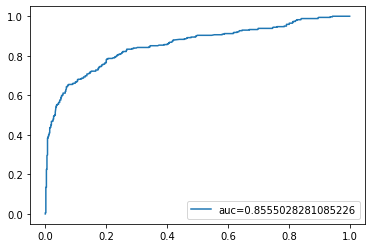

In [160]:
probas = log_reg.fit(X_train, y_train).predict_proba(X_train)
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)
plt.show()